<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fdeep_learning/SI_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/2105.08655.pdf
* https://sahilkhose.medium.com/paper-presentation-e9bd0f3fb0bf
* https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
* https://www.mdpi.com/2073-4441/15/5/875

# Imports

In [39]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid

In [2]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helpers

In [4]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [5]:
def extract_file(zip_path,specified_directory):
  # create a ZipFile object
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all contents to a specified directory
    zip_ref.extractall(specified_directory)


In [6]:
def read_images( flooded_path,non_flooded_path,width,height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    # loop through the images in the "flooded" folder
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) # resize the image to (image_size, image_size)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

    # loop through the images in the "non-flooded" folder
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) # resize the image to (image_size, image_size)
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [7]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

# Images reading 

In [8]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [9]:
flooded,non_flooded=read_images("dataset/flooded","dataset/non-flooded",300,400)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 224, 224, 3)
non_flooded images shapes (461, 224, 224, 3)


In [10]:
def split_data(shuffle=False,stratify=False):
  stratify_1=None
  stratify_2=None
  if stratify:
    stratify_1=y
    stratify_2=y_test

  # concatenate the flooded and non-flooded images into a single numpy array
  X = np.concatenate((flooded, non_flooded), axis=0)
  # create the corresponding labels
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  # 80% training, 10% validation, 10% testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=shuffle,stratify=stratify_2)
  return X_train, X_test,X_val, y_train, y_test,y_val

In [11]:
  X_train, X_test,X_val, y_train, y_test,y_val=split_data(shuffle=True)
  print(X_train.shape, y_train.shape)  # should output the shapes of the training data
  print(X_test.shape, y_test.shape)  # should output the shapes of the training data
  print(X_val.shape, y_val.shape)  # should output the shapes of the validation data

(737, 224, 224, 3) (737,)
(93, 224, 224, 3) (93,)
(92, 224, 224, 3) (92,)


In [12]:
show_images(X_train,y_train)

# Deep-learning approach

In [13]:
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    # convert the numpy arrays to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float()

    # create a PyTorch dataset from the tensors
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # create a PyTorch DataLoader for the training set
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # create a PyTorch DataLoader for the validation set
    validationloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # create a PyTorch DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, validationloader, testloader

In [14]:
trainloader, validationloader, testloader=create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64)

In [15]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [71]:
def create_resnet18_model(num_classes=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet18(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add a new final layer
    num_filters = model.fc.in_features
    model.fc = nn.Linear(num_filters, num_classes)

    # Move the model to the selected device
    model = model.to(device)

    return model

In [72]:
def create_resnet50_model(num_classes=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = models.resnet50(pretrained=True)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add a new final layer
    num_filters = model.fc.in_features
    model.fc = nn.Linear(num_filters, num_classes)

    # Move the model to the selected device
    model = model.to(device)

    return model

In [77]:
#num_classes in last layer 1 as it's binary classifcation problem
model = create_resnet18_model(num_classes=1)

In [78]:
#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model
#optimizer
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01) 
#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [79]:
def train_model(model, trainloader, validationloader, optimizer, loss_fn, n_epochs=20, early_stopping_tolerance=3, early_stopping_threshold=0.03):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    best_loss = float("inf")
    best_model_wts = None
    early_stopping_counter = 0
    losses = []
    val_losses = []
    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
            x_batch, y_batch = data
            x_batch = x_batch.permute(0, 3, 1, 2)
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float()
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            model.train()
            yhat = model(x_batch)
            loss = loss_fn(yhat, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() / len(trainloader)
            losses.append(loss.item())

        epoch_train_losses.append(epoch_loss)
        print('\nEpoch : {}, train loss : {}'.format(epoch+1, epoch_loss))

        with torch.no_grad():
            cum_loss = 0
            for x_batch, y_batch in validationloader:
                x_batch = x_batch.permute(0, 3, 1, 2)
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).float()
                y_batch = y_batch.to(device)

                model.eval()
                yhat = model(x_batch)
                val_loss = loss_fn(yhat, y_batch)
                cum_loss += val_loss.item() / len(validationloader)
                val_losses.append(val_loss.item())

            epoch_val_losses.append(cum_loss)
            print('Epoch : {}, val loss : {}'.format(epoch+1, cum_loss))

            if cum_loss <= best_loss:
                best_loss = cum_loss
                best_model_wts = model.state_dict()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter == early_stopping_tolerance or best_loss <= early_stopping_threshold:
                print("\nTerminating: early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, losses, val_losses, epoch_train_losses, epoch_val_losses

In [43]:
# Define parameter grid
param_grid = {
    'n_epochs': [30, 50, 100],
    'early_stopping_tolerance': [2, 3, 5],
    'early_stopping_threshold': [0.02, 0.03, 0.05]
}

# Generate all combinations of hyperparameters
param_list = list(ParameterGrid(param_grid))

# Train and evaluate the model for each parameter combination
best_model = None
best_loss = float("inf")
best_params = {}
for params in param_list:
    print("Training model with params:", params)
    model, _, _, _, epoch_val_losses = train_model(model, trainloader, validationloader, optimizer, loss_fn, **params)
    final_loss = epoch_val_losses[-1]
    print("Validation loss:", final_loss)
    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_params = params

print("Best model validation loss:", best_loss)
print("Best model hyperparameters:", best_params)

Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 2, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]



Epoch : 1, train loss : 0.6463799824317296
Epoch : 1, val loss : 0.5973637998104095


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 2, train loss : 0.5110223367810249
Epoch : 2, val loss : 0.4785991460084915


100%|██████████| 12/12 [00:01<00:00, 10.12it/s]



Epoch : 3, train loss : 0.41295789927244186
Epoch : 3, val loss : 0.4056612551212311


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]



Epoch : 4, train loss : 0.36653579523166024
Epoch : 4, val loss : 0.3511521965265274


100%|██████████| 12/12 [00:01<00:00, 10.97it/s]



Epoch : 5, train loss : 0.3279319579402606
Epoch : 5, val loss : 0.31852860748767853


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 6, train loss : 0.29312968999147415
Epoch : 6, val loss : 0.2909217029809952


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 7, train loss : 0.2598121625681718
Epoch : 7, val loss : 0.271346852183342


100%|██████████| 12/12 [00:01<00:00, 11.01it/s]



Epoch : 8, train loss : 0.24496015409628552
Epoch : 8, val loss : 0.254652664065361


100%|██████████| 12/12 [00:01<00:00, 10.93it/s]



Epoch : 9, train loss : 0.23649728174010912
Epoch : 9, val loss : 0.24142208695411682


100%|██████████| 12/12 [00:01<00:00, 11.02it/s]



Epoch : 10, train loss : 0.21556080877780912
Epoch : 10, val loss : 0.23116274923086166


100%|██████████| 12/12 [00:01<00:00, 10.96it/s]



Epoch : 11, train loss : 0.20656529689828554
Epoch : 11, val loss : 0.22020776569843292


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 12, train loss : 0.2020355872809887
Epoch : 12, val loss : 0.20973648130893707


100%|██████████| 12/12 [00:01<00:00, 10.47it/s]



Epoch : 13, train loss : 0.19018754363059998
Epoch : 13, val loss : 0.20733656734228134


100%|██████████| 12/12 [00:01<00:00,  9.94it/s]



Epoch : 14, train loss : 0.1900484325985114
Epoch : 14, val loss : 0.1986021101474762


100%|██████████| 12/12 [00:01<00:00, 10.33it/s]



Epoch : 15, train loss : 0.17987049743533134
Epoch : 15, val loss : 0.19674374163150787


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 16, train loss : 0.15921742593248686
Epoch : 16, val loss : 0.18629567325115204


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 17, train loss : 0.16649795509874823
Epoch : 17, val loss : 0.1861754208803177


100%|██████████| 12/12 [00:01<00:00, 11.09it/s]



Epoch : 18, train loss : 0.16517170270284018
Epoch : 18, val loss : 0.18072859197854996


100%|██████████| 12/12 [00:01<00:00, 10.96it/s]



Epoch : 19, train loss : 0.1564212590456009
Epoch : 19, val loss : 0.17529398202896118


100%|██████████| 12/12 [00:01<00:00, 10.96it/s]



Epoch : 20, train loss : 0.15717633751531443
Epoch : 20, val loss : 0.17210590094327927


100%|██████████| 12/12 [00:01<00:00, 11.08it/s]



Epoch : 21, train loss : 0.1505919409294923
Epoch : 21, val loss : 0.16607672721147537


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]



Epoch : 22, train loss : 0.14796899817883968
Epoch : 22, val loss : 0.16958139091730118


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 23, train loss : 0.15122602010766664
Epoch : 23, val loss : 0.16306225955486298


100%|██████████| 12/12 [00:01<00:00, 10.10it/s]



Epoch : 24, train loss : 0.14774246327579021
Epoch : 24, val loss : 0.1620440036058426


100%|██████████| 12/12 [00:01<00:00, 10.06it/s]



Epoch : 25, train loss : 0.14244775722424188
Epoch : 25, val loss : 0.157588429749012


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 26, train loss : 0.13698818379392227
Epoch : 26, val loss : 0.15842654556035995


100%|██████████| 12/12 [00:01<00:00, 10.90it/s]



Epoch : 27, train loss : 0.12607360072433949
Epoch : 27, val loss : 0.15324940532445908


100%|██████████| 12/12 [00:01<00:00, 10.83it/s]



Epoch : 28, train loss : 0.13833451767762503
Epoch : 28, val loss : 0.15928637981414795


100%|██████████| 12/12 [00:01<00:00,  9.26it/s]



Epoch : 29, train loss : 0.1341669106235107
Epoch : 29, val loss : 0.14953245222568512


100%|██████████| 12/12 [00:01<00:00,  8.82it/s]



Epoch : 30, train loss : 0.13635023993750414
Epoch : 30, val loss : 0.1476241871714592
Validation loss: 0.1476241871714592
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 2, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.89it/s]



Epoch : 1, train loss : 0.12272623305519423
Epoch : 1, val loss : 0.15147800743579865


100%|██████████| 12/12 [00:01<00:00, 10.83it/s]



Epoch : 2, train loss : 0.1257466208189726
Epoch : 2, val loss : 0.14731116592884064


100%|██████████| 12/12 [00:01<00:00, 10.82it/s]



Epoch : 3, train loss : 0.11818206061919528
Epoch : 3, val loss : 0.14749298244714737


100%|██████████| 12/12 [00:01<00:00,  9.95it/s]



Epoch : 4, train loss : 0.11786884876588981
Epoch : 4, val loss : 0.148124560713768

Terminating: early stopping
Validation loss: 0.148124560713768
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 2, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.03it/s]



Epoch : 1, train loss : 0.13424533729751903
Epoch : 1, val loss : 0.138303704559803


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 2, train loss : 0.11796295580764612
Epoch : 2, val loss : 0.15115320682525635


100%|██████████| 12/12 [00:01<00:00, 10.83it/s]



Epoch : 3, train loss : 0.12625841548045474
Epoch : 3, val loss : 0.1404329389333725

Terminating: early stopping
Validation loss: 0.1404329389333725
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 3, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 1, train loss : 0.11726143459479013
Epoch : 1, val loss : 0.13855400681495667


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 2, train loss : 0.1311761081839601
Epoch : 2, val loss : 0.13643984496593475


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 3, train loss : 0.10558233782649037
Epoch : 3, val loss : 0.13974931836128235


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]



Epoch : 4, train loss : 0.11467566962043443
Epoch : 4, val loss : 0.13750538229942322


100%|██████████| 12/12 [00:01<00:00, 10.82it/s]



Epoch : 5, train loss : 0.11582962796092033
Epoch : 5, val loss : 0.1444658413529396

Terminating: early stopping
Validation loss: 0.1444658413529396
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 3, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 1, train loss : 0.10710886927942435
Epoch : 1, val loss : 0.13492894917726517


100%|██████████| 12/12 [00:01<00:00, 10.24it/s]



Epoch : 2, train loss : 0.1195199890062213
Epoch : 2, val loss : 0.1349942311644554


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]



Epoch : 3, train loss : 0.11493116865555446
Epoch : 3, val loss : 0.13450834900140762


100%|██████████| 12/12 [00:01<00:00,  9.94it/s]



Epoch : 4, train loss : 0.10508956077198187
Epoch : 4, val loss : 0.13355150818824768


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 5, train loss : 0.12604829544822374
Epoch : 5, val loss : 0.1305067241191864


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 6, train loss : 0.10059722699224947
Epoch : 6, val loss : 0.13139062374830246


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 7, train loss : 0.09855926812936862
Epoch : 7, val loss : 0.13813668489456177


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 8, train loss : 0.0981238568201661
Epoch : 8, val loss : 0.13618822395801544

Terminating: early stopping
Validation loss: 0.13618822395801544
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 3, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 1, train loss : 0.1133962068706751
Epoch : 1, val loss : 0.13041429966688156


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 2, train loss : 0.09138390483955543
Epoch : 2, val loss : 0.13001957535743713


100%|██████████| 12/12 [00:01<00:00, 10.84it/s]



Epoch : 3, train loss : 0.10596696846187113
Epoch : 3, val loss : 0.13698145002126694


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]



Epoch : 4, train loss : 0.08891241966436307
Epoch : 4, val loss : 0.13036185503005981


100%|██████████| 12/12 [00:01<00:00,  9.86it/s]



Epoch : 5, train loss : 0.10019400995224713
Epoch : 5, val loss : 0.12904561311006546


100%|██████████| 12/12 [00:01<00:00,  9.74it/s]



Epoch : 6, train loss : 0.09862704481929539
Epoch : 6, val loss : 0.12645570933818817


100%|██████████| 12/12 [00:01<00:00, 10.25it/s]



Epoch : 7, train loss : 0.09962835628539325
Epoch : 7, val loss : 0.1281064637005329


100%|██████████| 12/12 [00:01<00:00, 10.83it/s]



Epoch : 8, train loss : 0.10403088728586835
Epoch : 8, val loss : 0.12478382885456085


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 9, train loss : 0.08832942104587953
Epoch : 9, val loss : 0.1282041296362877


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 10, train loss : 0.09530634184678395
Epoch : 10, val loss : 0.12391141802072525


100%|██████████| 12/12 [00:01<00:00, 10.85it/s]



Epoch : 11, train loss : 0.09518549932787816
Epoch : 11, val loss : 0.12431556731462479


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 12, train loss : 0.10146839047471683
Epoch : 12, val loss : 0.1271379329264164


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 13, train loss : 0.09206211473792791
Epoch : 13, val loss : 0.12276135012507439


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 14, train loss : 0.09555554948747158
Epoch : 14, val loss : 0.12426911666989326


100%|██████████| 12/12 [00:01<00:00,  9.98it/s]



Epoch : 15, train loss : 0.09138957069565852
Epoch : 15, val loss : 0.1299859881401062


100%|██████████| 12/12 [00:01<00:00, 10.02it/s]



Epoch : 16, train loss : 0.1065818437685569
Epoch : 16, val loss : 0.12344865873456001

Terminating: early stopping
Validation loss: 0.12344865873456001
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 5, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]



Epoch : 1, train loss : 0.09173670566330352
Epoch : 1, val loss : 0.1302127093076706


100%|██████████| 12/12 [00:01<00:00, 10.82it/s]



Epoch : 2, train loss : 0.08811624751736721
Epoch : 2, val loss : 0.12237510830163956


100%|██████████| 12/12 [00:01<00:00, 10.81it/s]



Epoch : 3, train loss : 0.08738141910483439
Epoch : 3, val loss : 0.1235402561724186


100%|██████████| 12/12 [00:01<00:00, 10.79it/s]



Epoch : 4, train loss : 0.09805881045758724
Epoch : 4, val loss : 0.12487885355949402


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 5, train loss : 0.08561936082939307
Epoch : 5, val loss : 0.12515459954738617


100%|██████████| 12/12 [00:01<00:00, 10.79it/s]



Epoch : 6, train loss : 0.08769705891609192
Epoch : 6, val loss : 0.1259319819509983


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 7, train loss : 0.08172279084101318
Epoch : 7, val loss : 0.1210966557264328


100%|██████████| 12/12 [00:01<00:00, 10.81it/s]



Epoch : 8, train loss : 0.07039683995147546
Epoch : 8, val loss : 0.12717856466770172


100%|██████████| 12/12 [00:01<00:00, 10.47it/s]



Epoch : 9, train loss : 0.08632934962709744
Epoch : 9, val loss : 0.12352697923779488


100%|██████████| 12/12 [00:01<00:00,  9.79it/s]



Epoch : 10, train loss : 0.1007754149225851
Epoch : 10, val loss : 0.13118524849414825


100%|██████████| 12/12 [00:01<00:00,  9.93it/s]



Epoch : 11, train loss : 0.08605673008908829
Epoch : 11, val loss : 0.1247388906776905


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 12, train loss : 0.07984082587063311
Epoch : 12, val loss : 0.11884675920009613


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 13, train loss : 0.08788971478740375
Epoch : 13, val loss : 0.12328414246439934


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 14, train loss : 0.07499927903215091
Epoch : 14, val loss : 0.12082342803478241


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 15, train loss : 0.08314764779061079
Epoch : 15, val loss : 0.1223936453461647


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 16, train loss : 0.08192200275758903
Epoch : 16, val loss : 0.1286623738706112


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 17, train loss : 0.08086468341449897
Epoch : 17, val loss : 0.12225310131907463

Terminating: early stopping
Validation loss: 0.12225310131907463
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 5, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 1, train loss : 0.08158343688895305
Epoch : 1, val loss : 0.12550126016139984


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 2, train loss : 0.07491050381213428
Epoch : 2, val loss : 0.1245231181383133


100%|██████████| 12/12 [00:01<00:00,  9.69it/s]



Epoch : 3, train loss : 0.0733664290358623
Epoch : 3, val loss : 0.11506511270999908


100%|██████████| 12/12 [00:01<00:00,  9.86it/s]



Epoch : 4, train loss : 0.0762497385342916
Epoch : 4, val loss : 0.12423473596572876


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]



Epoch : 5, train loss : 0.06754649275292952
Epoch : 5, val loss : 0.11711754277348518


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]



Epoch : 6, train loss : 0.07534649362787604
Epoch : 6, val loss : 0.12024066224694252


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 7, train loss : 0.07463817081103723
Epoch : 7, val loss : 0.11518563330173492


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 8, train loss : 0.07983274478465319
Epoch : 8, val loss : 0.12473303824663162

Terminating: early stopping
Validation loss: 0.12473303824663162
Training model with params: {'early_stopping_threshold': 0.02, 'early_stopping_tolerance': 5, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 1, train loss : 0.07292137977977593
Epoch : 1, val loss : 0.11744564771652222


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 2, train loss : 0.07581426032508412
Epoch : 2, val loss : 0.12046563997864723


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 3, train loss : 0.06716435713072619
Epoch : 3, val loss : 0.11716281250119209


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 4, train loss : 0.06571788309762876
Epoch : 4, val loss : 0.11623777821660042


100%|██████████| 12/12 [00:01<00:00, 10.28it/s]



Epoch : 5, train loss : 0.07248372506971161
Epoch : 5, val loss : 0.12023879215121269


100%|██████████| 12/12 [00:01<00:00,  9.83it/s]



Epoch : 6, train loss : 0.08530851639807226
Epoch : 6, val loss : 0.11707787588238716


100%|██████████| 12/12 [00:01<00:00,  9.88it/s]



Epoch : 7, train loss : 0.0625039596731464
Epoch : 7, val loss : 0.11407838761806488


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 8, train loss : 0.05930869746953249
Epoch : 8, val loss : 0.11520697921514511


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 9, train loss : 0.07112111120174329
Epoch : 9, val loss : 0.11907478794455528


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 10, train loss : 0.07711796959241232
Epoch : 10, val loss : 0.11788022145628929


100%|██████████| 12/12 [00:01<00:00, 10.81it/s]



Epoch : 11, train loss : 0.07738389975080888
Epoch : 11, val loss : 0.11730476468801498


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 12, train loss : 0.07615480603029331
Epoch : 12, val loss : 0.1240086741745472

Terminating: early stopping
Validation loss: 0.1240086741745472
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 2, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 1, train loss : 0.07578561641275883
Epoch : 1, val loss : 0.11208966001868248


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 2, train loss : 0.06518243004878362
Epoch : 2, val loss : 0.12173125147819519


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 3, train loss : 0.06339637112493315
Epoch : 3, val loss : 0.1159367486834526

Terminating: early stopping
Validation loss: 0.1159367486834526
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 2, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00,  9.79it/s]



Epoch : 1, train loss : 0.07651285951336224
Epoch : 1, val loss : 0.11205552890896797


100%|██████████| 12/12 [00:01<00:00,  9.97it/s]



Epoch : 2, train loss : 0.062447572126984596
Epoch : 2, val loss : 0.12054537609219551


100%|██████████| 12/12 [00:01<00:00, 10.34it/s]



Epoch : 3, train loss : 0.06778654890755813
Epoch : 3, val loss : 0.11713874340057373

Terminating: early stopping
Validation loss: 0.11713874340057373
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 2, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 1, train loss : 0.0677283777234455
Epoch : 1, val loss : 0.11351244896650314


100%|██████████| 12/12 [00:01<00:00, 10.81it/s]



Epoch : 2, train loss : 0.059650456377615534
Epoch : 2, val loss : 0.12297714501619339


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 3, train loss : 0.062193915558358036
Epoch : 3, val loss : 0.11404324322938919

Terminating: early stopping
Validation loss: 0.11404324322938919
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 3, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 1, train loss : 0.055653111543506384
Epoch : 1, val loss : 0.11671238020062447


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 2, train loss : 0.06748105244090159
Epoch : 2, val loss : 0.12102508172392845


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 3, train loss : 0.06260527266810338
Epoch : 3, val loss : 0.11583158001303673


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 4, train loss : 0.06660277179131904
Epoch : 4, val loss : 0.11566313728690147


100%|██████████| 12/12 [00:01<00:00, 10.11it/s]



Epoch : 5, train loss : 0.05861145087207356
Epoch : 5, val loss : 0.1197243332862854


100%|██████████| 12/12 [00:01<00:00, 10.01it/s]



Epoch : 6, train loss : 0.06039787083864213
Epoch : 6, val loss : 0.11352911964058876


100%|██████████| 12/12 [00:01<00:00,  9.99it/s]



Epoch : 7, train loss : 0.0550436998407046
Epoch : 7, val loss : 0.12251314893364906


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]



Epoch : 8, train loss : 0.06054429477080703
Epoch : 8, val loss : 0.11612140387296677


100%|██████████| 12/12 [00:01<00:00, 10.75it/s]



Epoch : 9, train loss : 0.05139313855518897
Epoch : 9, val loss : 0.11536251753568649

Terminating: early stopping
Validation loss: 0.11536251753568649
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 3, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 1, train loss : 0.057837973115965724
Epoch : 1, val loss : 0.11399530619382858


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 2, train loss : 0.05120539401347439
Epoch : 2, val loss : 0.12383466958999634


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 3, train loss : 0.060392802891631917
Epoch : 3, val loss : 0.1159752830862999


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 4, train loss : 0.06707959932585557
Epoch : 4, val loss : 0.11236551031470299


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 5, train loss : 0.06259440382321675
Epoch : 5, val loss : 0.12979604303836823


100%|██████████| 12/12 [00:01<00:00, 10.43it/s]



Epoch : 6, train loss : 0.05421585186074177
Epoch : 6, val loss : 0.11013494059443474


100%|██████████| 12/12 [00:01<00:00,  9.83it/s]



Epoch : 7, train loss : 0.062125896414120994
Epoch : 7, val loss : 0.11979016661643982


100%|██████████| 12/12 [00:01<00:00,  9.86it/s]



Epoch : 8, train loss : 0.06231034453958273
Epoch : 8, val loss : 0.11239349469542503


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 9, train loss : 0.06591055123135448
Epoch : 9, val loss : 0.12287764623761177

Terminating: early stopping
Validation loss: 0.12287764623761177
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 3, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 1, train loss : 0.05694450934727987
Epoch : 1, val loss : 0.1102568730711937


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 2, train loss : 0.046689307006696865
Epoch : 2, val loss : 0.11037154495716095


100%|██████████| 12/12 [00:01<00:00, 10.62it/s]



Epoch : 3, train loss : 0.071488109882921
Epoch : 3, val loss : 0.11700435355305672


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 4, train loss : 0.05442402899886172
Epoch : 4, val loss : 0.11330180242657661

Terminating: early stopping
Validation loss: 0.11330180242657661
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 5, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]



Epoch : 1, train loss : 0.06494920561090112
Epoch : 1, val loss : 0.11152539774775505


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 2, train loss : 0.058657711837440736
Epoch : 2, val loss : 0.12869726493954659


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]



Epoch : 3, train loss : 0.055384858045727015
Epoch : 3, val loss : 0.11154787987470627


100%|██████████| 12/12 [00:01<00:00, 10.14it/s]



Epoch : 4, train loss : 0.06050376625110705
Epoch : 4, val loss : 0.11533378437161446


100%|██████████| 12/12 [00:01<00:00,  9.91it/s]



Epoch : 5, train loss : 0.06058586854487657
Epoch : 5, val loss : 0.1116577610373497


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]



Epoch : 6, train loss : 0.04991429174939791
Epoch : 6, val loss : 0.10815197974443436


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 7, train loss : 0.05427700188010931
Epoch : 7, val loss : 0.11656060069799423


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 8, train loss : 0.057878195929030575
Epoch : 8, val loss : 0.11361422762274742


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 9, train loss : 0.0511391203229626
Epoch : 9, val loss : 0.11366992816329002


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 10, train loss : 0.054915076742569596
Epoch : 10, val loss : 0.11421685665845871


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 11, train loss : 0.049351964145898826
Epoch : 11, val loss : 0.1148122251033783

Terminating: early stopping
Validation loss: 0.1148122251033783
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 5, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 1, train loss : 0.06402528984472156
Epoch : 1, val loss : 0.11583447456359863


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 2, train loss : 0.0524097098968923
Epoch : 2, val loss : 0.11265548318624496


100%|██████████| 12/12 [00:01<00:00, 10.07it/s]



Epoch : 3, train loss : 0.049248814738045134
Epoch : 3, val loss : 0.1140204668045044


100%|██████████| 12/12 [00:01<00:00,  9.64it/s]



Epoch : 4, train loss : 0.045054823470612376
Epoch : 4, val loss : 0.11204365640878677


100%|██████████| 12/12 [00:01<00:00,  9.98it/s]



Epoch : 5, train loss : 0.04711241833865643
Epoch : 5, val loss : 0.12041263654828072


100%|██████████| 12/12 [00:01<00:00, 10.76it/s]



Epoch : 6, train loss : 0.06026680829624335
Epoch : 6, val loss : 0.11260905489325523


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 7, train loss : 0.048707286827266216
Epoch : 7, val loss : 0.11793824285268784


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 8, train loss : 0.049841585724304124
Epoch : 8, val loss : 0.11728406324982643


100%|██████████| 12/12 [00:01<00:00, 10.77it/s]



Epoch : 9, train loss : 0.0545679290468494
Epoch : 9, val loss : 0.11326391622424126

Terminating: early stopping
Validation loss: 0.11326391622424126
Training model with params: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 5, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 1, train loss : 0.05244533531367778
Epoch : 1, val loss : 0.11993952468037605


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 2, train loss : 0.05719104145343105
Epoch : 2, val loss : 0.11730218678712845


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 3, train loss : 0.05028762140621742
Epoch : 3, val loss : 0.11652924492955208


100%|██████████| 12/12 [00:01<00:00, 10.52it/s]



Epoch : 4, train loss : 0.05013611788551013
Epoch : 4, val loss : 0.11756597831845284


100%|██████████| 12/12 [00:01<00:00, 10.03it/s]



Epoch : 5, train loss : 0.05155596152568857
Epoch : 5, val loss : 0.1154726929962635


100%|██████████| 12/12 [00:01<00:00,  9.88it/s]



Epoch : 6, train loss : 0.0532878873248895
Epoch : 6, val loss : 0.11548637971282005


100%|██████████| 12/12 [00:01<00:00, 10.40it/s]



Epoch : 7, train loss : 0.04960300618161757
Epoch : 7, val loss : 0.12424494326114655


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 8, train loss : 0.04568141776447495
Epoch : 8, val loss : 0.11720345914363861


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]



Epoch : 9, train loss : 0.04556731553748249
Epoch : 9, val loss : 0.11830345913767815


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 10, train loss : 0.05549305910244584
Epoch : 10, val loss : 0.11426493898034096


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 11, train loss : 0.04813455231487751
Epoch : 11, val loss : 0.12553365156054497


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 12, train loss : 0.04662806230286756
Epoch : 12, val loss : 0.11659592762589455


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 13, train loss : 0.05683936861654123
Epoch : 13, val loss : 0.11400353163480759


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 14, train loss : 0.051531278528273106
Epoch : 14, val loss : 0.1377440243959427


100%|██████████| 12/12 [00:01<00:00,  9.95it/s]



Epoch : 15, train loss : 0.04928676784038544
Epoch : 15, val loss : 0.1155925765633583


100%|██████████| 12/12 [00:01<00:00,  9.82it/s]



Epoch : 16, train loss : 0.046491470032682024
Epoch : 16, val loss : 0.11682009696960449


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]



Epoch : 17, train loss : 0.054097793996334076
Epoch : 17, val loss : 0.1254638284444809


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 18, train loss : 0.051649839462091535
Epoch : 18, val loss : 0.11323317885398865


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 19, train loss : 0.047260284113387264
Epoch : 19, val loss : 0.11891051381826401


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]



Epoch : 20, train loss : 0.04584845170999567
Epoch : 20, val loss : 0.11397082731127739


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 21, train loss : 0.0440114208807548
Epoch : 21, val loss : 0.11499014869332314


100%|██████████| 12/12 [00:01<00:00, 10.60it/s]



Epoch : 22, train loss : 0.054065301083028316
Epoch : 22, val loss : 0.12082616239786148


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 23, train loss : 0.04841263902684054
Epoch : 23, val loss : 0.1263374388217926

Terminating: early stopping
Validation loss: 0.1263374388217926
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 2, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]



Epoch : 1, train loss : 0.04301432791786889
Epoch : 1, val loss : 0.12044771760702133


100%|██████████| 12/12 [00:01<00:00, 10.34it/s]



Epoch : 2, train loss : 0.05154503121351203
Epoch : 2, val loss : 0.11473483964800835


100%|██████████| 12/12 [00:01<00:00,  9.75it/s]



Epoch : 3, train loss : 0.043814185075461864
Epoch : 3, val loss : 0.12229691073298454


100%|██████████| 12/12 [00:01<00:00,  9.88it/s]



Epoch : 4, train loss : 0.03853584445702532
Epoch : 4, val loss : 0.11746466532349586

Terminating: early stopping
Validation loss: 0.11746466532349586
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 2, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.55it/s]



Epoch : 1, train loss : 0.045156062891085945
Epoch : 1, val loss : 0.11248819902539253


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 2, train loss : 0.04890604658673207
Epoch : 2, val loss : 0.12383640184998512


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 3, train loss : 0.04181016733249028
Epoch : 3, val loss : 0.11357983574271202

Terminating: early stopping
Validation loss: 0.11357983574271202
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 2, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 1, train loss : 0.03845195161799589
Epoch : 1, val loss : 0.12658289447426796


100%|██████████| 12/12 [00:01<00:00, 10.71it/s]



Epoch : 2, train loss : 0.052239067852497094
Epoch : 2, val loss : 0.11479205265641212


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 3, train loss : 0.04759775063333412
Epoch : 3, val loss : 0.128216665238142


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]



Epoch : 4, train loss : 0.042988883486638464
Epoch : 4, val loss : 0.1242944560945034

Terminating: early stopping
Validation loss: 0.1242944560945034
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 3, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00, 10.74it/s]



Epoch : 1, train loss : 0.038724033472438656
Epoch : 1, val loss : 0.11330219730734825


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]



Epoch : 2, train loss : 0.044001750337580844
Epoch : 2, val loss : 0.12254783883690834


100%|██████████| 12/12 [00:01<00:00,  9.76it/s]



Epoch : 3, train loss : 0.04041535205518206
Epoch : 3, val loss : 0.11401699855923653


100%|██████████| 12/12 [00:01<00:00, 10.13it/s]



Epoch : 4, train loss : 0.04465664721404513
Epoch : 4, val loss : 0.11637657508254051

Terminating: early stopping
Validation loss: 0.11637657508254051
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 3, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 1, train loss : 0.04145583355178436
Epoch : 1, val loss : 0.11257414519786835


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 2, train loss : 0.035719419829547405
Epoch : 2, val loss : 0.11550187692046165


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 3, train loss : 0.03959257838626703
Epoch : 3, val loss : 0.1133241131901741


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 4, train loss : 0.04331535752862692
Epoch : 4, val loss : 0.11971702054142952

Terminating: early stopping
Validation loss: 0.11971702054142952
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 3, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.73it/s]



Epoch : 1, train loss : 0.047219354581708714
Epoch : 1, val loss : 0.11595620587468147


100%|██████████| 12/12 [00:01<00:00, 10.62it/s]



Epoch : 2, train loss : 0.04983907612040639
Epoch : 2, val loss : 0.11511775478720665


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]



Epoch : 3, train loss : 0.04398849653080106
Epoch : 3, val loss : 0.11640186607837677


100%|██████████| 12/12 [00:01<00:00, 10.10it/s]



Epoch : 4, train loss : 0.0425548170072337
Epoch : 4, val loss : 0.12239516153931618


100%|██████████| 12/12 [00:01<00:00,  9.60it/s]



Epoch : 5, train loss : 0.054742901896437005
Epoch : 5, val loss : 0.11550894752144814

Terminating: early stopping
Validation loss: 0.11550894752144814
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 5, 'n_epochs': 30}


100%|██████████| 12/12 [00:01<00:00,  9.53it/s]



Epoch : 1, train loss : 0.03504769930926462
Epoch : 1, val loss : 0.13425500690937042


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]



Epoch : 2, train loss : 0.044232633585731186
Epoch : 2, val loss : 0.11172658577561378


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 3, train loss : 0.04547950206324458
Epoch : 3, val loss : 0.11221954599022865


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 4, train loss : 0.03777699389805396
Epoch : 4, val loss : 0.11879147961735725


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 5, train loss : 0.040789461849878236
Epoch : 5, val loss : 0.1218831054866314


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 6, train loss : 0.034841254353523254
Epoch : 6, val loss : 0.11820432916283607


100%|██████████| 12/12 [00:01<00:00, 10.63it/s]



Epoch : 7, train loss : 0.03985285231222709
Epoch : 7, val loss : 0.1197410300374031

Terminating: early stopping
Validation loss: 0.1197410300374031
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 5, 'n_epochs': 50}


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 1, train loss : 0.049306930663685
Epoch : 1, val loss : 0.1222931519150734


100%|██████████| 12/12 [00:01<00:00, 10.42it/s]



Epoch : 2, train loss : 0.04237274453043938
Epoch : 2, val loss : 0.11500878259539604


100%|██████████| 12/12 [00:01<00:00,  9.85it/s]



Epoch : 3, train loss : 0.04319731068486969
Epoch : 3, val loss : 0.1217372976243496


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]



Epoch : 4, train loss : 0.04138467647135257
Epoch : 4, val loss : 0.12661166861653328


100%|██████████| 12/12 [00:01<00:00, 10.54it/s]



Epoch : 5, train loss : 0.043694044618556895
Epoch : 5, val loss : 0.11754363030195236


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 6, train loss : 0.04304137903576096
Epoch : 6, val loss : 0.12063948065042496


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 7, train loss : 0.034511047725876175
Epoch : 7, val loss : 0.11628769710659981

Terminating: early stopping
Validation loss: 0.11628769710659981
Training model with params: {'early_stopping_threshold': 0.05, 'early_stopping_tolerance': 5, 'n_epochs': 100}


100%|██████████| 12/12 [00:01<00:00, 10.66it/s]



Epoch : 1, train loss : 0.04071881761774421
Epoch : 1, val loss : 0.12320107594132423


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 2, train loss : 0.04347985556038717
Epoch : 2, val loss : 0.12046817317605019


100%|██████████| 12/12 [00:01<00:00, 10.56it/s]



Epoch : 3, train loss : 0.03709812803814809
Epoch : 3, val loss : 0.12173384055495262


100%|██████████| 12/12 [00:01<00:00, 10.61it/s]



Epoch : 4, train loss : 0.03216979606077076
Epoch : 4, val loss : 0.12403449043631554


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]



Epoch : 5, train loss : 0.038668969646096236
Epoch : 5, val loss : 0.12218866124749184


100%|██████████| 12/12 [00:01<00:00,  9.80it/s]



Epoch : 6, train loss : 0.03361833343903224
Epoch : 6, val loss : 0.12020255997776985


100%|██████████| 12/12 [00:01<00:00,  9.74it/s]



Epoch : 7, train loss : 0.03174415766261518
Epoch : 7, val loss : 0.12208156660199165


100%|██████████| 12/12 [00:01<00:00, 10.22it/s]



Epoch : 8, train loss : 0.05658665772837897
Epoch : 8, val loss : 0.1343620903789997


100%|██████████| 12/12 [00:01<00:00, 10.67it/s]



Epoch : 9, train loss : 0.052230456843972206
Epoch : 9, val loss : 0.13104142621159554


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 10, train loss : 0.03695368184708059
Epoch : 10, val loss : 0.11842925101518631


100%|██████████| 12/12 [00:01<00:00, 10.62it/s]



Epoch : 11, train loss : 0.03616794726500908
Epoch : 11, val loss : 0.13426925987005234


100%|██████████| 12/12 [00:01<00:00, 10.55it/s]



Epoch : 12, train loss : 0.03759723234300812
Epoch : 12, val loss : 0.1287502385675907


100%|██████████| 12/12 [00:01<00:00, 10.65it/s]



Epoch : 13, train loss : 0.039578733267262585
Epoch : 13, val loss : 0.12176942825317383


100%|██████████| 12/12 [00:01<00:00, 10.70it/s]



Epoch : 14, train loss : 0.032969468738883734
Epoch : 14, val loss : 0.12422347441315651


100%|██████████| 12/12 [00:01<00:00, 10.69it/s]



Epoch : 15, train loss : 0.04570832848548889
Epoch : 15, val loss : 0.12491602450609207

Terminating: early stopping
Validation loss: 0.12491602450609207
Best model validation loss: 0.11326391622424126
Best model hyperparameters: {'early_stopping_threshold': 0.03, 'early_stopping_tolerance': 5, 'n_epochs': 50}


In [80]:
model, losses, val_losses, epoch_train_losses, epoch_val_losses = train_model(model, trainloader, validationloader, optimizer, loss_fn,n_epochs=50,early_stopping_tolerance=5,early_stopping_threshold=0.03)

100%|██████████| 12/12 [00:01<00:00, 10.03it/s]



Epoch : 1, train loss : 0.6323422143856685
Epoch : 1, val loss : 0.5371828675270081


100%|██████████| 12/12 [00:01<00:00, 10.21it/s]



Epoch : 2, train loss : 0.48762855927149457
Epoch : 2, val loss : 0.43711042404174805


100%|██████████| 12/12 [00:01<00:00, 10.16it/s]



Epoch : 3, train loss : 0.4068177714943886
Epoch : 3, val loss : 0.3565967381000519


100%|██████████| 12/12 [00:01<00:00, 10.49it/s]



Epoch : 4, train loss : 0.3549845317999522
Epoch : 4, val loss : 0.32057181000709534


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 5, train loss : 0.3193965889513493
Epoch : 5, val loss : 0.29885001480579376


100%|██████████| 12/12 [00:01<00:00, 10.99it/s]



Epoch : 6, train loss : 0.29228298490246135
Epoch : 6, val loss : 0.2784905433654785


100%|██████████| 12/12 [00:01<00:00, 11.02it/s]



Epoch : 7, train loss : 0.27468421186010045
Epoch : 7, val loss : 0.25812576711177826


100%|██████████| 12/12 [00:01<00:00, 10.99it/s]



Epoch : 8, train loss : 0.2642515612145265
Epoch : 8, val loss : 0.24393665045499802


100%|██████████| 12/12 [00:01<00:00, 11.04it/s]



Epoch : 9, train loss : 0.24635451162854832
Epoch : 9, val loss : 0.2383957803249359


100%|██████████| 12/12 [00:01<00:00, 11.06it/s]



Epoch : 10, train loss : 0.23497629662354785
Epoch : 10, val loss : 0.23352982103824615


100%|██████████| 12/12 [00:01<00:00, 10.95it/s]



Epoch : 11, train loss : 0.2133862152695656
Epoch : 11, val loss : 0.21532361954450607


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]



Epoch : 12, train loss : 0.23065904900431636
Epoch : 12, val loss : 0.21577094495296478


100%|██████████| 12/12 [00:01<00:00, 10.05it/s]



Epoch : 13, train loss : 0.2049837037920952
Epoch : 13, val loss : 0.20049556344747543


100%|██████████| 12/12 [00:01<00:00,  9.96it/s]



Epoch : 14, train loss : 0.21904944752653438
Epoch : 14, val loss : 0.1965942606329918


100%|██████████| 12/12 [00:01<00:00, 10.72it/s]



Epoch : 15, train loss : 0.1916678448518117
Epoch : 15, val loss : 0.1908382922410965


100%|██████████| 12/12 [00:01<00:00, 10.99it/s]



Epoch : 16, train loss : 0.18898740162452063
Epoch : 16, val loss : 0.18498393893241882


100%|██████████| 12/12 [00:01<00:00, 11.05it/s]



Epoch : 17, train loss : 0.18953427610298
Epoch : 17, val loss : 0.18908126652240753


100%|██████████| 12/12 [00:01<00:00, 11.06it/s]



Epoch : 18, train loss : 0.1869866289198399
Epoch : 18, val loss : 0.17882302403450012


100%|██████████| 12/12 [00:01<00:00, 10.99it/s]



Epoch : 19, train loss : 0.17211771632234257
Epoch : 19, val loss : 0.17737822234630585


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 20, train loss : 0.18690671647588417
Epoch : 20, val loss : 0.17429274320602417


100%|██████████| 12/12 [00:01<00:00, 11.07it/s]



Epoch : 21, train loss : 0.17044960210720697
Epoch : 21, val loss : 0.1705317348241806


100%|██████████| 12/12 [00:01<00:00, 10.97it/s]



Epoch : 22, train loss : 0.1658052566150824
Epoch : 22, val loss : 0.1782735213637352


100%|██████████| 12/12 [00:01<00:00, 10.53it/s]



Epoch : 23, train loss : 0.1688944734632969
Epoch : 23, val loss : 0.17486144602298737


100%|██████████| 12/12 [00:01<00:00, 10.08it/s]



Epoch : 24, train loss : 0.15398069781561693
Epoch : 24, val loss : 0.16342470049858093


100%|██████████| 12/12 [00:01<00:00, 10.32it/s]



Epoch : 25, train loss : 0.16764907042185465
Epoch : 25, val loss : 0.16982406377792358


100%|██████████| 12/12 [00:01<00:00, 10.92it/s]



Epoch : 26, train loss : 0.15106034527222315
Epoch : 26, val loss : 0.15969550609588623


100%|██████████| 12/12 [00:01<00:00, 11.01it/s]



Epoch : 27, train loss : 0.15042636170983315
Epoch : 27, val loss : 0.16726800799369812


100%|██████████| 12/12 [00:01<00:00, 10.80it/s]



Epoch : 28, train loss : 0.15151533608635268
Epoch : 28, val loss : 0.1554858237504959


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 29, train loss : 0.14475284330546856
Epoch : 29, val loss : 0.153505839407444


100%|██████████| 12/12 [00:01<00:00, 10.93it/s]



Epoch : 30, train loss : 0.14552986373504
Epoch : 30, val loss : 0.15204696357250214


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 31, train loss : 0.1368593759834766
Epoch : 31, val loss : 0.1502230018377304


100%|██████████| 12/12 [00:01<00:00, 11.05it/s]



Epoch : 32, train loss : 0.14015959203243256
Epoch : 32, val loss : 0.14984215795993805


100%|██████████| 12/12 [00:01<00:00, 10.95it/s]



Epoch : 33, train loss : 0.1553110076735417
Epoch : 33, val loss : 0.1473618820309639


100%|██████████| 12/12 [00:01<00:00, 10.09it/s]



Epoch : 34, train loss : 0.14442013142009577
Epoch : 34, val loss : 0.14683566987514496


100%|██████████| 12/12 [00:01<00:00, 10.15it/s]



Epoch : 35, train loss : 0.1396603770554066
Epoch : 35, val loss : 0.14245136827230453


100%|██████████| 12/12 [00:01<00:00, 10.64it/s]



Epoch : 36, train loss : 0.1412674381087224
Epoch : 36, val loss : 0.16281531751155853


100%|██████████| 12/12 [00:01<00:00, 10.93it/s]



Epoch : 37, train loss : 0.13630057126283646
Epoch : 37, val loss : 0.1467897817492485


100%|██████████| 12/12 [00:01<00:00, 10.98it/s]



Epoch : 38, train loss : 0.1369425418476264
Epoch : 38, val loss : 0.14364458620548248


100%|██████████| 12/12 [00:01<00:00, 10.92it/s]



Epoch : 39, train loss : 0.13202675990760326
Epoch : 39, val loss : 0.1480623558163643


100%|██████████| 12/12 [00:01<00:00, 10.92it/s]



Epoch : 40, train loss : 0.13847516663372517
Epoch : 40, val loss : 0.15099360048770905

Terminating: early stopping


In [81]:
def test_model(testloader, model, device):
    got_sample=False
    estimated = []
    true = []
    images_classified_flooded = []
    images_classified_non_flooded = []
    for x_batch, y_batch in testloader:
        x_batch = x_batch.permute(0, 3, 1, 2)
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device)
        model.eval()
        yhat = model(x_batch)
        yhat = torch.sigmoid(yhat)
        yhat = torch.round(yhat)
        if not got_sample:
            got_sample = True
            for i in range(len(yhat)):
                if yhat[i] == 1:
                    images_classified_flooded.append(x_batch[i].permute(1, 2, 0).cpu().detach().numpy())
                else:
                    images_classified_non_flooded.append(x_batch[i].permute(1, 2, 0).cpu().detach().numpy())
        estimated.append(yhat.cpu().detach().numpy())
        true.append(y_batch.cpu().detach().numpy())
    estimated = np.concatenate(estimated, axis=0)
    true = np.concatenate(true, axis=0)
    cm = confusion_matrix(true, estimated)
    report = classification_report(true, estimated)
    return estimated, true, cm, report, images_classified_flooded, images_classified_non_flooded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
estimated, true, cm, report, images_classified_flooded, images_classified_non_flooded = test_model(testloader, model, device)
print("confuison matrix: ",cm)
print(report)

confuison matrix:  [[50  1]
 [ 4 38]]
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95        51
         1.0       0.97      0.90      0.94        42

    accuracy                           0.95        93
   macro avg       0.95      0.94      0.95        93
weighted avg       0.95      0.95      0.95        93



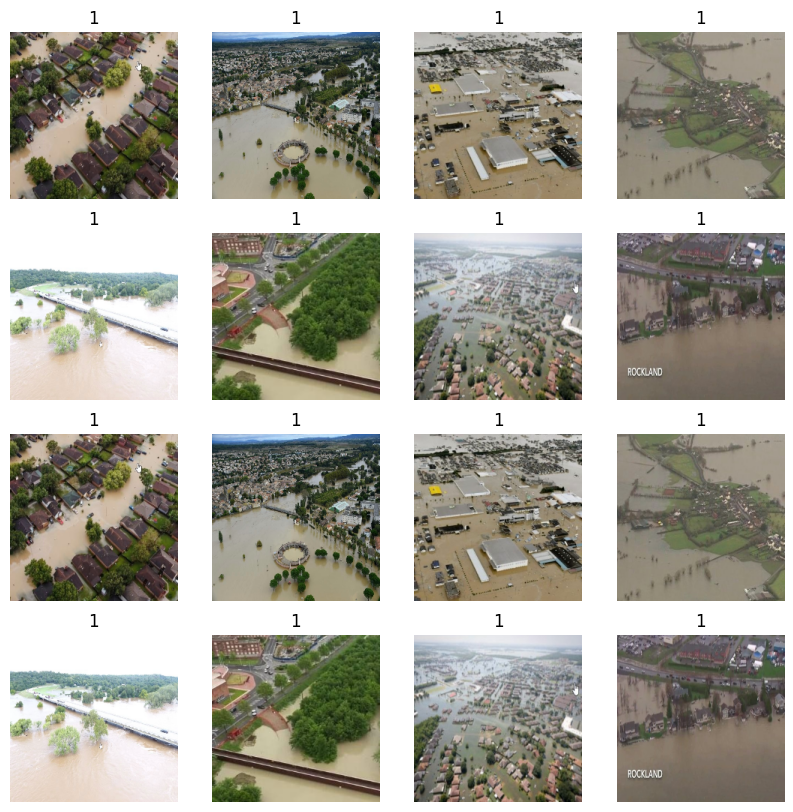

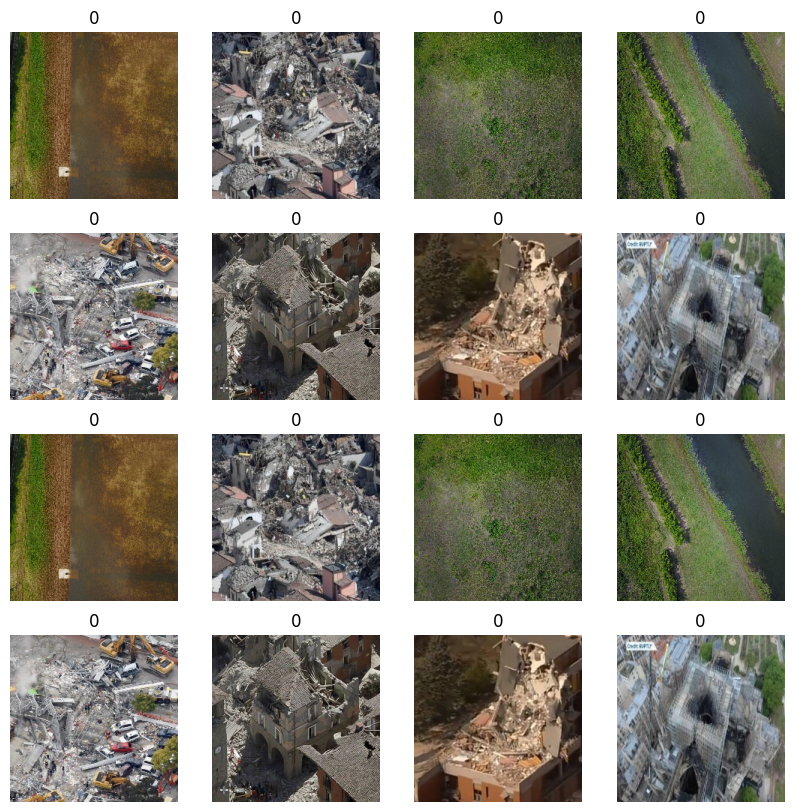

In [82]:
show_images(images_classified_flooded[0:16],[1]*16)
show_images(images_classified_non_flooded[0:16],[0]*16)